In [1]:
import numpy as np
import pandas as pd
# For visualizations
import matplotlib.pyplot as plt
# For regular expressions
import re
# For handling string
import string
# For performing mathematical operations
import math

from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from fuzzywuzzy import process, fuzz

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns

import re

EDA - Exploratory Data Anaysis

In [2]:
df = pd.read_parquet('C:/Users/Olimpio.Dasilva/Desktop/MACHINE LEARNING/DATA/reporting_ncr_all_transactions_202302131044.parquet')
pd.set_option('display.max_colwidth', None)
df.head(5)

,fi_id,account_id,transaction_id,amount,currency,txn_desc1,txn_desc2,region,transaction_timestamp,merchant_id,merchant_name,payment_agent,payment_agent_id,extract_date,filename,name
0,DI1004,Adb7cee870873375e9b71f97b49bb47f3,T8c3444845ea837d98f6492fbfeb996b1,300.0,USD,External Withdrawal TJMAXX,MASTERCAR NEEDHAM BANK BP BILL PAYMT,MT,2023-02-08,12897.0,TJ MAXX,Unknow Payment Agent,NaN,2023-02-13,FTS_CSLK_TRANSAC_20230212_100011.csv,Needham Bank
1,DI1004,A0d0f7d433a6f3cf4815fc5f7f77bbf73,Td0c9a05199c034f282105c258edf4c90,42.5,USD,POS Withdrawal (FIP) SUNOCO,*63 SUNOCO *63 FRAMINGHAM MA(8631),None,2023-02-08,12696.0,SUNOCO,Unknow Payment Agent,NaN,2023-02-13,FTS_CSLK_TRANSAC_20230212_100011.csv,Needham Bank
2,DI1004,Ac9fb869c66b83cb7a6f0d84e5f37d60a,Tf9ce6b86a4e1379eb600c9af4c1ae90e,250.0,USD,External Withdrawal BARCLAYCARD,US CREDITCARD,None,2023-02-07,NaN,Unknow Merchant,Unknow Payment Agent,NaN,2023-02-13,FTS_CSLK_TRANSAC_20230212_100011.csv,Needham Bank
3,DI1004,Ade85fffa5da73362bd6b0522721820a3,T4f1445aa5fd536f09d13bd6918c057fb,42.5,USD,ATM Withdrawal (FIP) SUNSHINE,LLC-60 464 MAIN ST WEST SPRINGFI MA(5681),None,2023-02-08,NaN,Unknow Merchant,Unknow Payment Agent,NaN,2023-02-13,FTS_CSLK_TRANSAC_20230212_100011.csv,Needham Bank
4,DI1004,A1f3390a72bf035a48a21fce7d72df58a,T7be6870fc08e30c48fd78836885adf12,114.5,USD,POS Withdrawal (FIP) NNT,DESTINATION 735 PROVIDENCE HWY DEDHAM MA(7169),None,2023-02-11,NaN,Unknow Merchant,Unknow Payment Agent,NaN,2023-02-13,FTS_CSLK_TRANSAC_20230212_100011.csv,Needham Bank


In [3]:
df.shape

(2280287, 16)

In [4]:
df.isnull().sum()
#df.dropna(inplace=True)

fi_id                          0
account_id                     0
transaction_id                 0
amount                         1
currency                       1
txn_desc1                    199
txn_desc2                 166629
region                   1941391
transaction_timestamp          2
merchant_id              1144835
merchant_name                  1
payment_agent                  1
payment_agent_id         2076646
extract_date                   1
filename                       1
name                           1
dtype: int64

In [5]:
df.nunique()

fi_id                        207
account_id                159294
transaction_id           2180340
amount                     75569
currency                       1
txn_desc1                 298314
txn_desc2                1292160
region                        50
transaction_timestamp        464
merchant_id                 1791
merchant_name               1794
payment_agent                 16
payment_agent_id              15
extract_date                   8
filename                       9
name                         207
dtype: int64

In [6]:
# feature scaling and label encoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
df_cp = df[['amount','txn_desc1','txn_desc2','region','payment_agent','merchant_name']].copy(deep=True)
df_cp = df_cp.apply(LabelEncoder().fit_transform)
df_cp.head()


,amount,txn_desc1,txn_desc2,region,payment_agent,merchant_name
0,29682,104027,592925,25,14,1591
1,4249,184107,20644,50,14,1500
2,24930,101414,1096902,50,14,1668
3,4249,23649,572056,50,14,1668
4,11449,183611,389034,50,14,1668


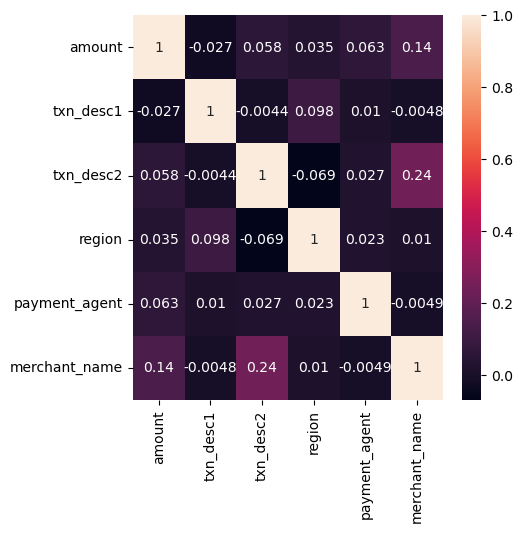

In [7]:
plt.subplots(figsize=(5, 5))
sns.heatmap(df_cp.corr(), annot=True);

Unknown Merchant Names

In [8]:
df_unknown_merchs = df.copy(deep=True)
df_unknown_merchs = df_unknown_merchs[df["merchant_name"].str.contains("Unknow Merchant") == True]
df_unknown_merchs.shape

(1146663, 16)

Known Merchant Names

In [9]:
# Selecting only known merchants names from the original dataset
df_known_merchs = df[['transaction_id','txn_desc1','txn_desc2','payment_agent','merchant_name']].copy(deep=True)
df_known_merchs = df_known_merchs[df["merchant_name"].str.contains("Unknow Merchant") == False]

In [10]:
# Number of transactions with known merchant names
len(df_known_merchs) 

1133623

In [11]:
# Total number of known merchants
len(df_known_merchs.merchant_name.unique())

1793

In [12]:
# Total number of occurences per merchant name 
(df_known_merchs.merchant_name).value_counts()

AMAZON.COM            96572
WALMART               78246
MCDONALD'S            37171
APPLE STORE           34993
TARGET                25209
                      ...  
SERAPHINE                 1
CASA.COM                  1
HABIT BURGER GRILL        1
CHARLOTTE TILBURY         1
REJUVENATION              1
Name: merchant_name, Length: 1793, dtype: int64

In [13]:
# Concatenating transaction descriptions columns
df_known_merchs["TRANSACTION_DETAILS"] = df_known_merchs['txn_desc1'].astype(str) +" %%%%% "+ df_known_merchs['txn_desc2'].astype(str)

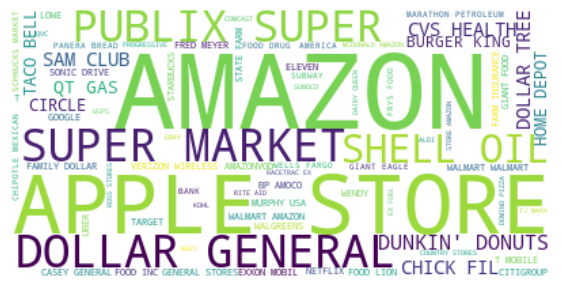

In [14]:
# Copy of the afs merchant names column
df_known_merchs['AFS_PAYMENT_AGENTS'] = df_known_merchs['payment_agent'] 
# Copy of the afs merchant names column
df_known_merchs['AFS_MECHANT_NAMES'] = df_known_merchs['merchant_name']
# Droping original cols
df_known_merchs = df_known_merchs.drop(['txn_desc1', 'txn_desc2','payment_agent','merchant_name'], axis=1)

# Word cloud for more frequent merchant names
text = " ".join(i for i in df_known_merchs.AFS_MECHANT_NAMES)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(7,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [15]:
df_known_merchs

,transaction_id,TRANSACTION_DETAILS,AFS_PAYMENT_AGENTS,AFS_MECHANT_NAMES
0,T8c3444845ea837d98f6492fbfeb996b1,External Withdrawal TJMAXX %%%%% MASTERCAR NEEDHAM BANK BP BILL PAYMT,Unknow Payment Agent,TJ MAXX
1,Td0c9a05199c034f282105c258edf4c90,POS Withdrawal (FIP) SUNOCO %%%%% *63 SUNOCO *63 FRAMINGHAM MA(8631),Unknow Payment Agent,SUNOCO
5,T644d8104fbda356aaa98203bb5723f4e,POS Withdrawal (FIP) KOHLS 0575 %%%%% 1 WORCESTER RD FRAMINGHAM MA(8806),Unknow Payment Agent,KOHL'S
7,Tce633b3d9de130218e493c10b9fbe09a,POS Withdrawal (FIS) %%%%% AMAZON.COM*HE3H AMAZON.COM SEATTLE WA(6966),Unknow Payment Agent,AMAZON.COM
12,T1704c488eec6363fa58d5b2b3a770c7b,POS Withdrawal (FIS) %%%%% AMAZON.COM*HR0D AMAZON.COM SEATTLE WA(6966),Unknow Payment Agent,AMAZON.COM
...,...,...,...,...
2280281,Tb6218cdcf4a032d9997b39e00fb29a49,Withdrawal Debit STARBUCKS %%%%% STORE 10231 CASSELBERRY FLUS,Unknow Payment Agent,STARBUCKS
2280282,T5c9fb7f0ee2d30bd92c1a91b2aba3a12,Withdrawal Debit APPLE CASH %%%%% 1INFINITELOOPCAUS,Unknow Payment Agent,APPLE STORE
2280283,T834ffe1138e832ac8a2983595d70a15e,Withdrawal Debit 7-ELEVEN %%%%% Winter GardenFLUS,Unknow Payment Agent,7 ELEVEN
2280285,T2f4d9990708d3c35a8ceec8f342df567,Withdrawal Debit MICHAELS %%%%% STORES 2017 CONYERS GAUS,Unknow Payment Agent,MICHAELS STORES


In [16]:
def check_names(merchant, t_details):
    
    # Variations for merchant name column
    merchant_1 = merchant
    merchant_2 = merchant_1.lower()
    merchant_3 = re.sub("[\\\\/:*?'#<>|-]", '', merchant_2)
    merchant_4 = re.sub(' ', '', merchant_2)
    merchant_5 = re.sub('[.com/]', ' ', merchant_2)
    merch_list = merchant_1.split() + merchant_2.split() + merchant_3.split() + merchant_4.split() + merchant_5.split() + merchant.split()
    
    # Variations for transaction details column
    t_details_1 = t_details
    t_details_2 = t_details.lower()
    t_details_3 = re.sub("[\\\\/:*?'#<>|-]", '', t_details_2)
    t_details_4 = re.sub("[.com/]", " ",t_details_2)
    t_details_5 = re.sub("[\\\\/:*?'#<>|-]", ' ', t_details_2)
    
    # Merchants mentioned in transaction description w/ variations
    comp_1 = re.sub("Prime", "AMAZONVOD",t_details_1)
    comp_2 = re.sub("VZWRLSS", "VERIZON WIRELESS",t_details_1)
    comp_3 = re.sub("WM", "WALMART",t_details_1)
    
    # Creating a list of conversions to check if merchants are mentioned in transation descriotions 
    details_lis = t_details_2.split()
    details_lis_1 = t_details_1.split() + t_details_2.split() + t_details_3.split() + details_lis + t_details_4.split() + t_details_5.split() + comp_1.split() + comp_2.split() + comp_3.split() + t_details.split()
    
    # Conditions to check if words are in transaction strings
    if (merchant in t_details_3 or t_details_3 in merchant or 
        (merchant_2 in t_details_3 or t_details_3 in merchant_2) or 
        (merchant_3 in t_details_3 or t_details_3 in merchant_3) or
        (merchant_4 in t_details_3 or t_details_3 in merchant_4) or
        (merchant_1 in t_details_3 or t_details_1 in merchant_4) or
        (merchant_1 in details_lis_1 or merchant_4 in details_lis)or
        (any(item in merch_list for item in details_lis_1)) or
        (merchant_1[:4] in t_details_1)):
        return True
    else:
        return False
    

In [17]:
# # Funciton to detect similarity between 2 results
# def similarity(a, b):
#     s_score = fuzz.ratio(a, b)
#     print(s_score)
#     return s_score

In [18]:
# # Similarity colunm representation - TO CHECK
# df_known_merchs['SIMILARITY'] = df_known_merchs.apply(lambda x: fuzz.ratio(x['AFS_MECHANT_NAMES'], x['TRANSACTION_DETAILS']), axis=1)

In [19]:
# Checking if merchant names are mentioned in the transaction description
df_known_merchs['CHECK_MERCH_TRA'] = df_known_merchs.apply(lambda x: check_names(x.AFS_MECHANT_NAMES, x.TRANSACTION_DETAILS), axis=1)
df_known_merchs.head(5)

,transaction_id,TRANSACTION_DETAILS,AFS_PAYMENT_AGENTS,AFS_MECHANT_NAMES,CHECK_MERCH_TRA
0,T8c3444845ea837d98f6492fbfeb996b1,External Withdrawal TJMAXX %%%%% MASTERCAR NEEDHAM BANK BP BILL PAYMT,Unknow Payment Agent,TJ MAXX,True
1,Td0c9a05199c034f282105c258edf4c90,POS Withdrawal (FIP) SUNOCO %%%%% *63 SUNOCO *63 FRAMINGHAM MA(8631),Unknow Payment Agent,SUNOCO,True
5,T644d8104fbda356aaa98203bb5723f4e,POS Withdrawal (FIP) KOHLS 0575 %%%%% 1 WORCESTER RD FRAMINGHAM MA(8806),Unknow Payment Agent,KOHL'S,True
7,Tce633b3d9de130218e493c10b9fbe09a,POS Withdrawal (FIS) %%%%% AMAZON.COM*HE3H AMAZON.COM SEATTLE WA(6966),Unknow Payment Agent,AMAZON.COM,True
12,T1704c488eec6363fa58d5b2b3a770c7b,POS Withdrawal (FIS) %%%%% AMAZON.COM*HR0D AMAZON.COM SEATTLE WA(6966),Unknow Payment Agent,AMAZON.COM,True


In [20]:
# Merchant name in the transaction description
(df_known_merchs['CHECK_MERCH_TRA'] == True).sum() 

1118311

In [21]:
df_known_merchs_cp = df_known_merchs[['transaction_id','TRANSACTION_DETAILS','AFS_PAYMENT_AGENTS','AFS_MECHANT_NAMES','CHECK_MERCH_TRA']].copy(deep=True)
df_known_merchs_cp['CHECK_MERCH_TRA']= df_known_merchs_cp['CHECK_MERCH_TRA'].replace(False,0)
df_known_merchs_cp['CHECK_MERCH_TRA'] = df_known_merchs_cp['CHECK_MERCH_TRA'].replace(True,1)
df_known_merchs_cp.head()



,transaction_id,TRANSACTION_DETAILS,AFS_PAYMENT_AGENTS,AFS_MECHANT_NAMES,CHECK_MERCH_TRA
0,T8c3444845ea837d98f6492fbfeb996b1,External Withdrawal TJMAXX %%%%% MASTERCAR NEEDHAM BANK BP BILL PAYMT,Unknow Payment Agent,TJ MAXX,1
1,Td0c9a05199c034f282105c258edf4c90,POS Withdrawal (FIP) SUNOCO %%%%% *63 SUNOCO *63 FRAMINGHAM MA(8631),Unknow Payment Agent,SUNOCO,1
5,T644d8104fbda356aaa98203bb5723f4e,POS Withdrawal (FIP) KOHLS 0575 %%%%% 1 WORCESTER RD FRAMINGHAM MA(8806),Unknow Payment Agent,KOHL'S,1
7,Tce633b3d9de130218e493c10b9fbe09a,POS Withdrawal (FIS) %%%%% AMAZON.COM*HE3H AMAZON.COM SEATTLE WA(6966),Unknow Payment Agent,AMAZON.COM,1
12,T1704c488eec6363fa58d5b2b3a770c7b,POS Withdrawal (FIS) %%%%% AMAZON.COM*HR0D AMAZON.COM SEATTLE WA(6966),Unknow Payment Agent,AMAZON.COM,1


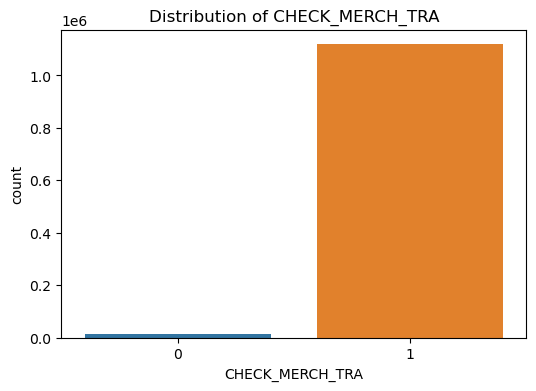

In [22]:
plt.figure(figsize=(6, 4))
sns.countplot(x="CHECK_MERCH_TRA", data=df_known_merchs_cp)
plt.title("Distribution of CHECK_MERCH_TRA");

In [23]:
# Number of merchant names in transaction details
df_check_true = pd.DataFrame()
df_check_true = df_known_merchs.loc[df_known_merchs['CHECK_MERCH_TRA'] == True]
len(df_check_true)

1118311

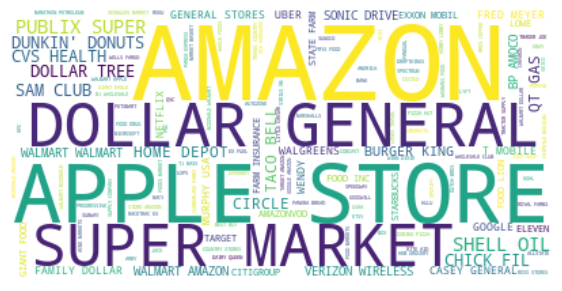

In [24]:
# Word cloud for more frequent merchant names WHEN merchant name is in transaction description
text = " ".join(i for i in df_check_true.AFS_MECHANT_NAMES)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(7,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [25]:
# # Total number of occurences per merchant name 
# (df_check_true.AFS_MECHANT_NAMES).value_counts()

In [26]:
# # Merchant name not in the transaction description
# (df_known_merchs['CHECK_MERCH_TRA'] == False).sum() 

In [27]:
# Number of merchant names not in transaction details
df_check_false = pd.DataFrame()
df_check_false = df_known_merchs.loc[df_known_merchs['CHECK_MERCH_TRA'] == False]
len(df_check_false)

15312

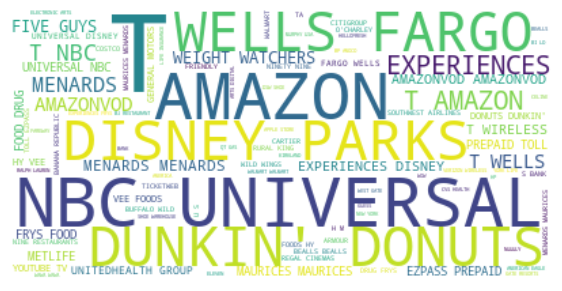

In [28]:
# Word cloud for more frequent merchant names WHEN merchant name is NOT in transaction description
text = " ".join(i for i in df_check_false.AFS_MECHANT_NAMES)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(7,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [29]:
# # Total number of occurences per merchant name WHEN merchant name is not in transation details
# (df_check_false.AFS_MECHANT_NAMES).value_counts()

In [30]:
# Merchant names not mentioned in transaction description
df_known_merchs.loc[df_known_merchs['CHECK_MERCH_TRA']==False] 


,transaction_id,TRANSACTION_DETAILS,AFS_PAYMENT_AGENTS,AFS_MECHANT_NAMES,CHECK_MERCH_TRA
49,T4c5223bdca413f2c90a06a7fe713df4b,POS Withdrawal (FIS) Peacock %%%%% X1166 P Peacock X1166 Premi New York NY(4680),Unknow Payment Agent,NBC UNIVERSAL,False
853,T142e232779e53315a40c4485d2e5ab29,Withdrawal Debit Card %%%%% Withdrawal WDW AFRICA HUB CART LAKE BUENA VI FL,Unknow Payment Agent,DISNEY PARKS AND EXPERIENCES,False
2520,T844ee4d07ac733f3a72ab79fac42931b,Withdrawal Debit Card %%%%% Withdrawal Kindle Unltd*HE9XN00D0 888-802-3080 WA,Unknow Payment Agent,AMAZON.COM,False
2578,Tc0eafe0c07eb33a9bf7c1a430ba83504,Withdrawal ACH %%%%% Withdrawal ATT,Unknow Payment Agent,AT&T,False
2853,T3b1d225b8ec23c1cb07e4fb90b291634,Withdrawal Debit Card %%%%% Withdrawal ATT* BILL PAYMENT *0500 TX,Unknow Payment Agent,AT&T,False
...,...,...,...,...,...
2279499,Tdf191273d9703694b090fcea1e56811e,Withdrawal Debit WDW AP %%%%% Monthly Payment 888-*0 CAUS,Unknow Payment Agent,DISNEY PARKS AND EXPERIENCES,False
2279542,T76f4107ee40c3326b8ed54d6ac1929aa,Withdrawal Debit SP %%%%% EPCOT-COSMICREWIND- HTTPSEPCOTCOSCAUS,Unknow Payment Agent,DISNEY PARKS AND EXPERIENCES,False
2279724,T650da175289e39fda77110d338a0c671,Withdrawal Debit WDW AUNTIE %%%%% GRAVITY' LAKE BUENA VIFLUS,Unknow Payment Agent,DISNEY PARKS AND EXPERIENCES,False
2279725,Td56d350e784c36f58e63389a136c3412,Withdrawal Debit WDW BREW-WING %%%%% F&W LAKE BUENA VIFLUS,Unknow Payment Agent,DISNEY PARKS AND EXPERIENCES,False


Payment Agents VS Merchants

In [31]:
df_known_payment_agents = df_known_merchs.copy(deep=True)
# Known payment agent names
df_known_payment_agents = df_known_payment_agents.loc[df_known_payment_agents['AFS_PAYMENT_AGENTS'] != 'Unknow Payment Agent']
#df_known_payment_agents = df_known_payment_agents.drop(['txn_desc1', 'txn_desc2','payment_agent','merchant_name'], axis=1)
df_known_payment_agents

,transaction_id,TRANSACTION_DETAILS,AFS_PAYMENT_AGENTS,AFS_MECHANT_NAMES,CHECK_MERCH_TRA
36,T2c410431c12a3cba8c911c78acfe4cf5,POS Withdrawal (FIS) APPLE CASH %%%%% - SE APPLE CASH - SENT M 877-233-8552 CA(0002),APPLE CASH,APPLE STORE,True
137,T8056037293cc3d2da36ed8b0888ff502,POS Withdrawal (FIS) GOOGLE %%%%% *GOOGLE GOOGLE *GOOGLE STOR MOUNTAIN VIEW CA(5047),GOOGLE,GOOGLE,True
173,T2240a31b6fc13f19a39fe6c82622b8b9,POS Withdrawal (FIS) GOOGLE %%%%% *NEXTERS GOOGLE *NEXTERS MOUNTAIN VIEW CA(7985),GOOGLE,GOOGLE,True
221,T6e9596b6801636dfa7d9c1592b861544,POS Withdrawal (FIS) VENMO %%%%% *GRUBHUB VENMO *GRUBHUB *4430 NY(0003),GRUBHUB.COM,GRUBHUB.COM,True
329,T84090ff3823f31d9ad36cd537ad3cdf1,Withdrawal POS %%%%% GIANT-EAG 600 Towne Sq Pittsburgh PA,SQUARE,GIANT EAGLE,True
...,...,...,...,...,...
2279368,T3f78b8d9749e3e2a92ea9d3bf7a150d6,Withdrawal Debit PAYPAL *UBER %%%%% EATS 402-935-7733 CAUS,PAYPAL,UBEREATS,True
2279484,T906aac20983f388084b3d48ce0fdd3a7,Withdrawal Debit DD DOORDASH %%%%% DOLLARGEN 855-973-1040 CAUS,DOORDASH,DOLLAR GENERAL,True
2279978,T24d1f314d14b3fa3a73ffff48e531f74,Withdrawal Debit DD DOORDASH %%%%% POPEYES 855-973-1040 CAUS,DOORDASH,POPEYE'S,True
2279998,T2a411624b79735669aa48601ff78172a,Withdrawal Debit SONNYS %%%%% FRANCHISE CO ECOolo.com FLUS,OLO,SONNY'S BBQ,True


In [32]:
# # Copy of the afs merchant names column
# df_known_payment_agents['AFS_PAYMENT_AGENTS'] = df_known_payment_agents['payment_agent'] 

In [33]:
# Number of total occurences per payment agents
(df_known_payment_agents.AFS_PAYMENT_AGENTS).value_counts()

GOOGLE             15767
PAYPAL              7899
DOORDASH            4709
APPLE CASH          2900
SQUARE              2360
ROKU                2143
GRUBHUB.COM         1352
OLO                  712
INSTACART            596
SQUARE CASH APP      299
VENMO                285
LEVELUP               67
PRICELINE             50
SEAMLESS.COM          20
FACEBOOK               7
Name: AFS_PAYMENT_AGENTS, dtype: int64

In [34]:
# Total number of payment agents
len(df_known_payment_agents.AFS_PAYMENT_AGENTS.unique())

15

In [35]:
# Number of transactions with known payment agents
len(df_known_payment_agents)

39166

In [36]:
# Function to compare payment agent names with merchant names
def compare_occurences(agent, merchant):
    agent = agent.split()
    merchant = merchant.split()
    # Conditions to check if words are in transaction strings
    if (merchant in agent or agent in merchant or
        (any(item in merchant for item in agent)) or
        (merchant[:3] in agent)):
        return True
    else:
        return False

In [37]:
# Checking if merchant names and payment agents are same
df_known_payment_agents['CHECK_MERCH_AGTS'] = df_known_payment_agents.apply(lambda x: compare_occurences(x.AFS_MECHANT_NAMES, x.AFS_PAYMENT_AGENTS), axis=1)
df_known_payment_agents.head()

,transaction_id,TRANSACTION_DETAILS,AFS_PAYMENT_AGENTS,AFS_MECHANT_NAMES,CHECK_MERCH_TRA,CHECK_MERCH_AGTS
36,T2c410431c12a3cba8c911c78acfe4cf5,POS Withdrawal (FIS) APPLE CASH %%%%% - SE APPLE CASH - SENT M 877-233-8552 CA(0002),APPLE CASH,APPLE STORE,True,True
137,T8056037293cc3d2da36ed8b0888ff502,POS Withdrawal (FIS) GOOGLE %%%%% *GOOGLE GOOGLE *GOOGLE STOR MOUNTAIN VIEW CA(5047),GOOGLE,GOOGLE,True,True
173,T2240a31b6fc13f19a39fe6c82622b8b9,POS Withdrawal (FIS) GOOGLE %%%%% *NEXTERS GOOGLE *NEXTERS MOUNTAIN VIEW CA(7985),GOOGLE,GOOGLE,True,True
221,T6e9596b6801636dfa7d9c1592b861544,POS Withdrawal (FIS) VENMO %%%%% *GRUBHUB VENMO *GRUBHUB *4430 NY(0003),GRUBHUB.COM,GRUBHUB.COM,True,True
329,T84090ff3823f31d9ad36cd537ad3cdf1,Withdrawal POS %%%%% GIANT-EAG 600 Towne Sq Pittsburgh PA,SQUARE,GIANT EAGLE,True,False


In [38]:
# Same merchant names and payment agents
len(df_known_payment_agents.loc[df_known_payment_agents['CHECK_MERCH_AGTS']==True])

21075

In [39]:
# Merchant names and payment agents are diferent
len(df_known_payment_agents.loc[df_known_payment_agents['CHECK_MERCH_AGTS']==False])

18091

In [40]:
# Number of rows with known Agents
len(df_known_payment_agents)

39166

In [41]:
df_known_payment_agents

,transaction_id,TRANSACTION_DETAILS,AFS_PAYMENT_AGENTS,AFS_MECHANT_NAMES,CHECK_MERCH_TRA,CHECK_MERCH_AGTS
36,T2c410431c12a3cba8c911c78acfe4cf5,POS Withdrawal (FIS) APPLE CASH %%%%% - SE APPLE CASH - SENT M 877-233-8552 CA(0002),APPLE CASH,APPLE STORE,True,True
137,T8056037293cc3d2da36ed8b0888ff502,POS Withdrawal (FIS) GOOGLE %%%%% *GOOGLE GOOGLE *GOOGLE STOR MOUNTAIN VIEW CA(5047),GOOGLE,GOOGLE,True,True
173,T2240a31b6fc13f19a39fe6c82622b8b9,POS Withdrawal (FIS) GOOGLE %%%%% *NEXTERS GOOGLE *NEXTERS MOUNTAIN VIEW CA(7985),GOOGLE,GOOGLE,True,True
221,T6e9596b6801636dfa7d9c1592b861544,POS Withdrawal (FIS) VENMO %%%%% *GRUBHUB VENMO *GRUBHUB *4430 NY(0003),GRUBHUB.COM,GRUBHUB.COM,True,True
329,T84090ff3823f31d9ad36cd537ad3cdf1,Withdrawal POS %%%%% GIANT-EAG 600 Towne Sq Pittsburgh PA,SQUARE,GIANT EAGLE,True,False
...,...,...,...,...,...,...
2279368,T3f78b8d9749e3e2a92ea9d3bf7a150d6,Withdrawal Debit PAYPAL *UBER %%%%% EATS 402-935-7733 CAUS,PAYPAL,UBEREATS,True,False
2279484,T906aac20983f388084b3d48ce0fdd3a7,Withdrawal Debit DD DOORDASH %%%%% DOLLARGEN 855-973-1040 CAUS,DOORDASH,DOLLAR GENERAL,True,False
2279978,T24d1f314d14b3fa3a73ffff48e531f74,Withdrawal Debit DD DOORDASH %%%%% POPEYES 855-973-1040 CAUS,DOORDASH,POPEYE'S,True,False
2279998,T2a411624b79735669aa48601ff78172a,Withdrawal Debit SONNYS %%%%% FRANCHISE CO ECOolo.com FLUS,OLO,SONNY'S BBQ,True,False
